## Homework1

Team: AiCoders
Members:
* Alessio_Parato
* Jan31415
* Vel


Task: binary classification of plants that are divided into two categories according to their state of health


### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Colab Notebooks/Homework1/Submission_Homework1_AiCoders/'
%cd /content/drive/MyDrive/Colab Notebooks/Homework1/Submission_Homework1_AiCoders

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Homework1/Submission_Homework1_AiCoders


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Import other libraries
#import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

2.14.0


### Useful Functions
In this part we created some very useful Functions for the entire file

* save and load functions
* plot function
* function to validate automaticly:
  In the validation we decided to collect different model predictions of modified test sets.
  * not modified test set
  * horizontally flipped test set
  * vertically flipped test set
  * right-down shifted test set
  * right-upper shifted test set
  * left-down shifted test set
  * left-upper shifted test set

  We also calculated the mean of the first three predictions, the mean of the shifted predictions and the mean of all predictions.

In [16]:
def save_model(model, model_name, path, loss, val_loss, acc, val_acc, plot=False):
  #
  #the functions saves the model and the history of a fit
  #
  if plot:
    tfk.utils.plot_model(model, to_file=path+'/model_pic.png', show_shapes=True, expand_nested=True)
  model.save(path+'/'+model_name)
  pd.DataFrame(loss).to_csv(path+'/'+model_name+'/loss.csv')
  pd.DataFrame(val_loss).to_csv(path+'/'+model_name+'/val_loss.csv')
  pd.DataFrame(acc).to_csv(path+'/'+model_name+'/acc.csv')
  pd.DataFrame(val_acc).to_csv(path+'/'+model_name+'/val_acc.csv')

def load_model(path):
  #
  #the functions loads the model and the history of a fit
  #
  model = tfk.models.load_model(path)
  loss = pd.read_csv(path+'/loss.csv')
  val_loss = pd.read_csv(path+'/val_loss.csv')
  acc = pd.read_csv(path+'/acc.csv')
  val_acc = pd.read_csv(path+'/val_acc.csv')

  return (model, loss, val_loss, acc, val_acc)

def plot_two(histo1, histo2, label1 = 'Transfer', label2 = 'Fine Tuning', histo3=None, label3=None):
  #
  #the function creates two different plots of two given histories
  # * one of the Binary Crossentropy (loss-function)
  # * one of the accuracy
  #
  # Create and display plots for training and validation loss
  plt.figure(figsize=(15,4))
  plt.plot(np.array(histo1[0])[:,1], label=label1, alpha=.8, color='blue', linestyle='--')
  plt.plot(np.array(histo1[1])[:,1], label=label1, alpha=.8, color='blue')
  plt.plot(np.array(histo2[0])[:,1], label=label2, alpha=.8, color='red', linestyle='--')
  plt.plot(np.array(histo2[1])[:,1], label=label2, alpha=.8, color='red')
  if label3 != None:
    plt.plot(np.array(histo3[0])[:,1], label=label3, alpha=.8, color='green', linestyle='--')
    plt.plot(np.array(histo3[1])[:,1], label=label3, alpha=.8, color='green')

  plt.title('Binary Crossentropy: Training is dashed')
  plt.legend()
  plt.grid(alpha=.3)

  # Create and display plots for training and validation accuracy
  plt.figure(figsize=(15,4))
  plt.plot(np.array(histo1[2])[:,1], label=label1, alpha=.8, color='blue', linestyle='--')
  plt.plot(np.array(histo1[3])[:,1], label=label1, alpha=.8, color='blue')
  plt.plot(np.array(histo2[2])[:,1], label=label2, alpha=.8, color='red', linestyle='--')
  plt.plot(np.array(histo2[3])[:,1], label=label2, alpha=.8, color='red')
  if label3!=None:
    plt.plot(np.array(histo3[2])[:,1], label=label3, alpha=.8, color='red', linestyle='--')
    plt.plot(np.array(histo3[3])[:,1], label=label3, alpha=.8, color='red')
  plt.title('Accuracy: Training is dashed')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

def validation(model, x_data, y_lab, bool_print=False, shift=20):
  #
  #calculate three different prediction of the given model
  # * normal prediction of the x_data
  # * prediction of the horizontally flipped x_data
  # * prediction of the vertically flipped x_data
  # * prediction of the right-down shifted x_data
  # * prediction of the right-upper shifted x_data
  # * prediction of the left-down shifted x_data
  # * prediction of the left-upper shifted x_data
  #
  #then the function calculates all the accuracies and returns them all
  #
  mod_pred = model.predict(x_data.copy())
  test_accuracy1 = accuracy_score(y_lab, np.round(mod_pred))

  pred_data_f_h = np.flip(x_data.copy(), axis=1) #horizontal
  mod_pred_f_h = model.predict(pred_data_f_h)
  test_accuracy2 = accuracy_score(y_lab, np.round(mod_pred_f_h))

  pred_data_f_v = np.flip(x_data.copy(), axis=2)#vertical
  mod_pred_f_v = model.predict(pred_data_f_v)
  test_accuracy3 = accuracy_score(y_lab, np.round(mod_pred_f_v))

  #mean
  mod_pred_mean = (1/3)*(mod_pred + mod_pred_f_h + mod_pred_f_v)
  test_accuracy4 = accuracy_score(y_lab, np.round(mod_pred_mean))

  #right down shift
  x_data_shift_rd = np.roll(x_data, (shift,shift), axis=(1,2))
  x_data_shift_rd[:,0:shift,:,:] = np.roll(np.flip(x_data[:,0:shift,:,:],axis=1), shift, axis=2)
  x_data_shift_rd[:,:,0:shift,:] = np.roll(np.flip(x_data[:,:,0:shift,:],axis=2), shift, axis=1)
  pred_data_shift_rd = model.predict(x_data_shift_rd)
  accuracy_shift_rd = accuracy_score(y_lab, np.round(pred_data_shift_rd))

  #right upper shift
  x_data_shift_ru = np.roll(x_data, (-shift,shift), axis=(1,2))
  x_data_shift_ru[:,96-shift:,:,:] = np.roll(np.flip(x_data[:,96-shift:,:,:],axis=1), shift, axis=2)
  x_data_shift_ru[:,:,:shift,:] = np.roll(np.flip(x_data[:,:,:shift,:], axis=2), -shift, axis=1)
  pred_data_shift_ru = model.predict(x_data_shift_ru)
  accuracy_shift_ru = accuracy_score(y_lab, np.round(pred_data_shift_ru))

  #left down shift
  x_data_shift_ld = np.roll(x_data, (shift,-shift), axis=(1,2))
  x_data_shift_ld[:,:shift,:,:] = np.roll(np.flip(x_data[:,:shift,:,:],axis=1), -shift, axis=2)
  x_data_shift_ld[:,:,96-shift:,:] = np.roll(np.flip(x_data[:,:,96-shift:,:],axis=2), shift, axis=1)
  pred_data_shift_ld = model.predict(x_data_shift_ld)
  accuracy_shift_ld = accuracy_score(y_lab, np.round(pred_data_shift_ld))

  #left upper shift
  x_data_shift_lu = np.roll(x_data, (-shift,-shift), axis=(1,2))
  x_data_shift_lu[:,96-shift:,:,:] = np.roll(np.flip(x_data[:,96-shift:,:,:],axis=1), -shift, axis=2)
  x_data_shift_lu[:,:,96-shift:,:] = np.roll(np.flip(x_data[:,:,96-shift:,:],axis=2), -shift, axis=1)
  pred_data_shift_lu = model.predict(x_data_shift_lu)
  accuracy_shift_lu = accuracy_score(y_lab, np.round(pred_data_shift_lu))

  #Mean of the shifted data
  pred_mean_shift = (1/5)*(mod_pred+pred_data_shift_rd+pred_data_shift_ru+pred_data_shift_ld+pred_data_shift_lu)
  accuracy_shift_mean = accuracy_score(y_lab, np.round(pred_mean_shift))

  #Mean of all
  pred_mean = (1/7)*(mod_pred+pred_data_shift_rd+pred_data_shift_ru+pred_data_shift_ld+pred_data_shift_lu+ mod_pred_f_h + mod_pred_f_v)
  accuracy_mean = accuracy_score(y_lab, np.round(pred_mean))

  if bool_print:
    print(f'Accuracy of the original test set: {round(test_accuracy1,4)}')
    print(f'Accuracy of the horizontally flipped test set: {round(test_accuracy2,4)}')
    print(f'Accuracy of the vertically flipped test set: {round(test_accuracy3,4)}')
    print(f'Mean accuracy of the three predictions above: {round(test_accuracy4,4)}')

    print(f'Accuracy of the right-down shifted test set: {round(accuracy_shift_rd,4)}')
    print(f'Accuracy of the right-upper shifted test set: {round(accuracy_shift_ru,4)}')
    print(f'Accuracy of the left-down shifted test set: {round(accuracy_shift_ld,4)}')
    print(f'Accuracy of the left-upper shifted test set: {round(accuracy_shift_lu,4)}')
    print(f'Mean accuracy of the shifted test sets: {round(accuracy_shift_mean,4)}')

    print(f'Mean accuracy of all test sets: {round(accuracy_mean,4)}')

  return [test_accuracy1, test_accuracy2, test_accuracy3, test_accuracy4,
          accuracy_shift_rd,accuracy_shift_ru,accuracy_shift_ld,accuracy_shift_lu,
          accuracy_shift_mean,accuracy_mean]

### Load data

In [ ]:
#loads the unzipped dataset and divides it into data and labels
complete_data = np.load('Data/public_data.npz', allow_pickle=True)
print(f'List of all files: {complete_data.files}')
data = complete_data['data']
labels = complete_data['labels']

print(f'Shape of the data: {data.shape}')
print(f'Shape of the labels: {labels.shape}')

List of all files: ['data', 'labels']
Shape of the data: (5200, 96, 96, 3)
Shape of the labels: (5200,)


In [ ]:
labels_cate = pd.get_dummies(labels).to_numpy()
test_size=0.2
x_train_val, x_test, y_train_val, y_test = train_test_split(data, labels_cate, random_state=seed, test_size=test_size, stratify=np.argmax(labels_cate,axis=1))

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=seed, test_size=test_size, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"x_train_del shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val_del shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test_del shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train_del shape: (3328, 96, 96, 3), y_train shape: (3328, 2)
x_val_del shape: (832, 96, 96, 3), y_val shape: (832, 2)
x_test_del shape: (1040, 96, 96, 3), y_test shape: (1040, 2)


In [ ]:
x_train_mobile = preprocess_input(x_train)
x_val_mobile = preprocess_input(x_val)
x_test_mobile = preprocess_input(x_test)

argMax_y_train = np.argmax(y_train, axis=-1)
argMax_y_val = np.argmax(y_val, axis=-1)
argMax_y_test = np.argmax(y_test, axis=-1)

### Process the dataset

Here we go through the images and observe some images that have nothing to do with the binary classification of plants.

We collect them and delete them from the dataset.

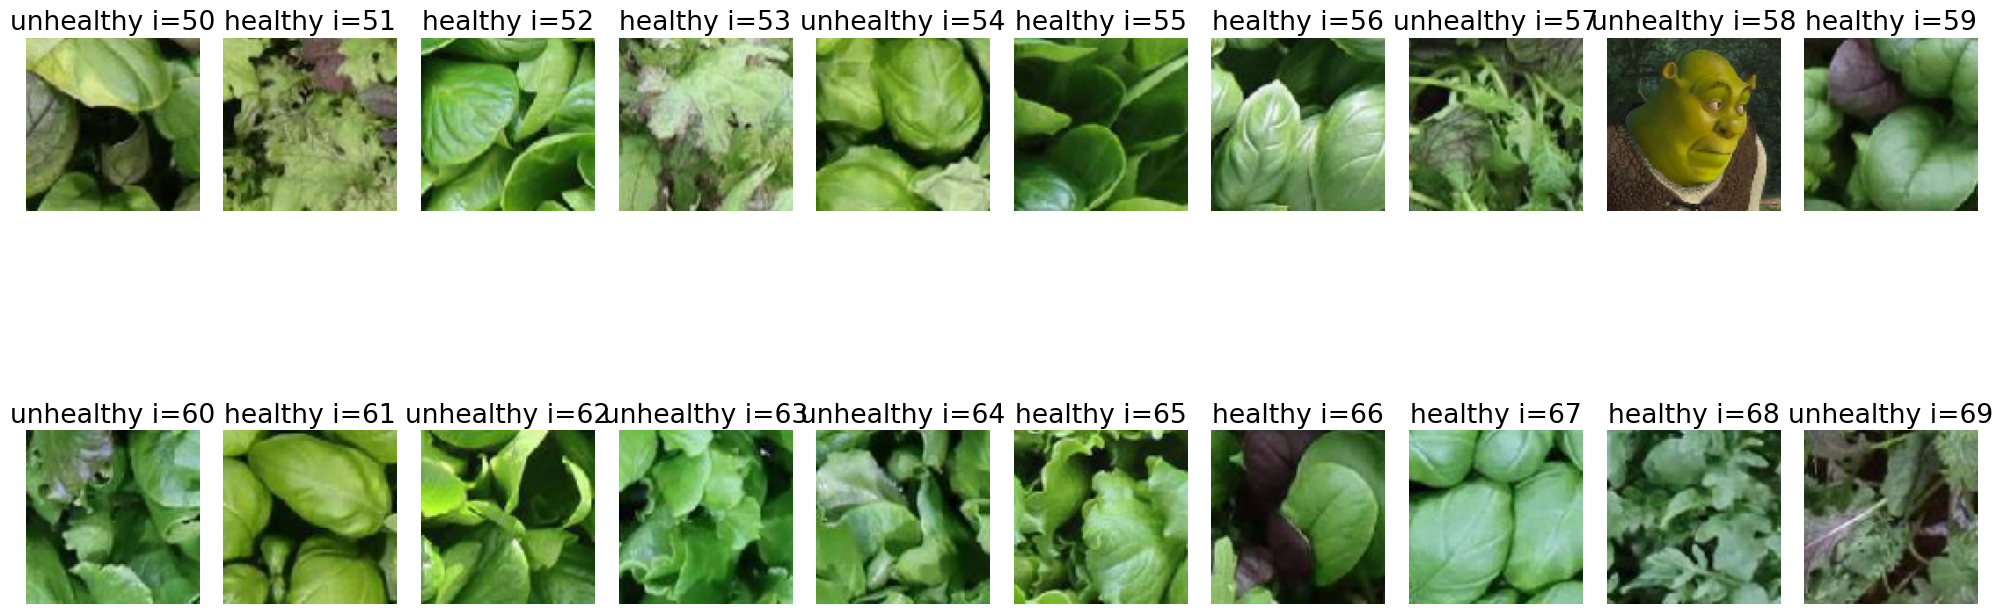

In [ ]:
# Number of images to display
start = 50
num_img = 20

# Create subplots for displaying items
fig, axes = plt.subplots(2, 10, figsize=(20, 10))
counter = 0
for i in range(start, start+num_img):
    ax = axes[counter//10, i%10]
    ax.set_title(f'{labels[i]} i={i}')
    ax.imshow(np.clip((data[i] / 255).astype(np.float32), 0, 255))
    ax.axis('off')
    counter +=1
del counter
plt.tight_layout()
plt.show()

We detected some pictures which are not leafs, so we decided to go through all the pictures and select the ones which are no leafs

In [ ]:
noLeafsList = [58,95,137,138,171,207,338,412,434,486,506,529,571,599,622,658,692,701,723,
      725,753,779,783,827,840,880,898,901,961,971,974,989,1028,1044,1064,1065,1101,1149,1172,1190,1191,1265,1268,1280,1333,1384,1443,
      1466,1483,1528,1541,1554,1594,1609,1630,1651,1690,1697,1752,1757,1759,1806,
      1828,1866,1903,1938,1939,1977,1981,1988,2022,2081,2090,2150,2191,2192,2198,2261,2311,2380,2328,2348,2451,2453,2435,
      2426,2496,2487,2581,2593,2564,2515,2596,2663,2665,2675,2676,2727,2734,2736,
      2755,2779,2796,2800,2830,2831,2839,2864,2866,2889,2913,2929,2937,3033,3049,3055,3086,3105,3108,3144,3155,3286,3376,3410,3436,3451,3488,3490,
      3572,3583,3666,3688,3700,3740,3770,3800,3801,3802,3806,3811,3821,3835,3862,
      3885,3896,3899,3904,3927,3931,3946,3950,3964,3988,3989,4049,4055,4097,4100,4118,4144,4150,4282,4310,4314,4316,4368,4411,4475,4476,
      4503,4507,4557,4605,4618,4694,4719,4735,4740,4766,4779,4837,4848,4857,4860,
      4883,4897,4903,4907,4927,5048,5080,5082,5121,5143,5165,5171]
print(f'Number of no leafs pictures: {len(noLeafsList)}')

fig, axes = plt.subplots(20, 10, figsize=(20, 40))
counter = 0
for i in range(0, len(noLeafsList)):
    ax = axes[counter//10, i%10]
    ax.set_title(f"i={noLeafsList[i]}")
    ax.imshow(np.clip((data[noLeafsList[i]] / 255).astype(np.float32), 0, 255))
    ax.axis('off')
    counter += 1
del counter, i
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Next step is to delete the non-sense data and save the cleaned data

In [ ]:
data_del = np.delete(data, noLeafsList, 0)
lab_del = np.delete(labels, noLeafsList, 0)
print(f'Shape of the cleaned data: {data_del.shape}')
print(f'Shape of the cleaned labels: {lab_del.shape}')
np.savez('Data/changed_data', data_del=data_del, lab_del=lab_del)
del data_del, lab_del

Shape of the cleaned data: (5004, 96, 96, 3)
Shape of the cleaned labels: (5004,)


### Final load of the data

Finally we are able to load the cleaned dataset.

In [4]:
complete_data_del = np.load('Data/changed_data.npz', allow_pickle=True)
data_del = complete_data_del['data_del']
labels_del = complete_data_del['lab_del']

### Split in train, validation and test

* Training set
* Validation set
* Test set

In [5]:
labels_del_cate = pd.get_dummies(labels_del).to_numpy()
test_size=0.2
x_train_val_del, x_test_del, y_train_val_del, y_test_del = train_test_split(data_del, labels_del_cate, random_state=seed, test_size=test_size, stratify=np.argmax(labels_del_cate,axis=1))

x_train_del, x_val_del, y_train_del, y_val_del = train_test_split(x_train_val_del, y_train_val_del, random_state=seed, test_size=test_size, stratify=np.argmax(y_train_val_del,axis=1))

# Print shapes of the datasets
print(f"x_train_del shape: {x_train_del.shape}, y_train shape: {y_train_del.shape}")
print(f"x_val_del shape: {x_val_del.shape}, y_val shape: {y_val_del.shape}")
print(f"x_test_del shape: {x_test_del.shape}, y_test shape: {y_test_del.shape}")

x_train_del shape: (3202, 96, 96, 3), y_train shape: (3202, 2)
x_val_del shape: (801, 96, 96, 3), y_val shape: (801, 2)
x_test_del shape: (1001, 96, 96, 3), y_test shape: (1001, 2)


We want to use the MobileNetV2 as the CNN part so we have to normalize the data

and we will try the classification with the sigmoid function

In [6]:
x_train_del_mobile = preprocess_input(x_train_del)
x_val_del_mobile = preprocess_input(x_val_del)
x_test_del_mobile = preprocess_input(x_test_del)

argMax_y_train_del = np.argmax(y_train_del, axis=-1)
argMax_y_val_del = np.argmax(y_val_del, axis=-1)
argMax_y_test_del = np.argmax(y_test_del, axis=-1)

### Build the model

In this part we created the main model and some components of the model.

In [41]:
def block(block_name, dropout_rate = 1/6):
    block = tf.keras.Sequential([
        tfkl.Dense(units=100, activation='relu', name='hiddenDense1'),
        tfkl.Dropout(dropout_rate, name='dropout_1'),
        tfkl.Dense(units=100, activation='relu', name='hiddenDense2'),
        tfkl.Dropout(dropout_rate, name='dropout_2'),
        tfkl.Dense(units=100, activation='relu', name='hiddenDense3'),
        tfkl.Dropout(dropout_rate, name='dropout_3'),
    ], name=block_name)
    return block

def block_withLambda(block_name, dropout_rate = 1/6, l2_lambda = 2e-5):
    block = tf.keras.Sequential([
        tfkl.Dense(units=100, activation='relu', name='hiddenDense1',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
        tfkl.Dropout(dropout_rate, name='dropout_1'),
        tfkl.Dense(units=100, activation='relu', name='hiddenDense2',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
        tfkl.Dropout(dropout_rate, name='dropout_2'),
        tfkl.Dense(units=100, activation='relu', name='hiddenDense3',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
        tfkl.Dropout(dropout_rate, name='dropout_3'),
    ], name=block_name)
    return block

def build_model(model_name, preprocessing_block, mobile_block, dropout=1/6):
  inputs = tfk.Input(shape=(96, 96, 3),name='Input')
  preprocessing = preprocessing_block(inputs)
  cnn_out = mobile_block(preprocessing)

  d1 = tfkl.Dense(units=100, activation='relu', name='Dense1')(cnn_out)
  b1 = block('block_1')(d1)
  add1 = tfkl.Add(name='add1')([d1,b1])

  d2 = tfkl.Dense(units=100, activation='relu', name='Dense2')(add1)
  b2 = block('block_2')(d2)
  add2 = tfkl.Add(name='add2')([add1,b2])

  d4 = tfkl.Dense(units=100, activation='relu', name='Dense4')(add2)

  outputs = tfkl.Dense(1, activation='sigmoid', name='out')(d4)

  model = tfk.Model(inputs=inputs, outputs=outputs, name=model_name)
  return model

### Plan

The plan in this version is to use the MobileNetV2 model and classifier which is made out of Dense-Layers and blocks of Dense-Layers combined with Dropout-Layers.

### 1. Fit

First we build the model and trained only the Classifier.

To prevent overfitting we want to use Image Augmentation and for simplification we only used RandomFlip- and RandomTranslation-Layers at the beginning.

In [40]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
  )
mobile.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [41]:
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(mode='horizontal_and_vertical', name='randomFlip'),
        tfkl.RandomTranslation(0.2,0.2,name='randomTrans'),
    ], name='preprocessing')

In [44]:
model1 = build_model('model1', preprocessing, mobile)
model1.summary()

Model: "model1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['Input[0][0]']               
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 1280)                 2257984   ['preprocessing[1][0]']       
 ional)                                                                                           
                                                                                                  
 Dense1 (Dense)              (None, 100)                  128100    ['mobilenetv2_1.00_96[1][

In [24]:
model1.get_layer('block_1').summary()

Model: "block_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hiddenDense1 (Dense)        (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 hiddenDense2 (Dense)        (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 hiddenDense3 (Dense)        (None, 100)               10100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
Total params: 30300 (118.36 KB)
Trainable params: 30300 (11

In [ ]:
model1.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model1.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del)
  ).history

Epoch 1/100
13/13 [==============================] - 45s 3s/step - loss: 0.7164 - accuracy: 0.5959 - val_loss: 0.5954 - val_accuracy: 0.7104
Epoch 2/100
13/13 [==============================] - 44s 3s/step - loss: 0.5579 - accuracy: 0.7227 - val_loss: 0.5126 - val_accuracy: 0.7466
Epoch 3/100
13/13 [==============================] - 31s 2s/step - loss: 0.5160 - accuracy: 0.7477 - val_loss: 0.4854 - val_accuracy: 0.7678
Epoch 4/100
13/13 [==============================] - 33s 3s/step - loss: 0.4820 - accuracy: 0.7626 - val_loss: 0.4533 - val_accuracy: 0.7803
Epoch 5/100
13/13 [==============================] - 42s 3s/step - loss: 0.4672 - accuracy: 0.7773 - val_loss: 0.4419 - val_accuracy: 0.7753
Epoch 6/100
13/13 [==============================] - 35s 3s/step - loss: 0.4407 - accuracy: 0.7929 - val_loss: 0.4287 - val_accuracy: 0.7903
Epoch 7/100
13/13 [==============================] - 35s 3s/step - loss: 0.4293 - accuracy: 0.7926 - val_loss: 0.4165 - val_accuracy: 0.7978
Epoch 8/100
1

In [ ]:
save_model(model1, 'model1', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)
del history, model1

### 1. Fit Load

The Load-parts are only for loading already saved results.

In [10]:
model1, loss1, val_loss1, acc1, val_acc1 = load_model('Sigmoid/model1')

histo1 = [loss1, val_loss1, acc1, val_acc1]
print('Validation accuracy:')
val_acc1 = validation(model1, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc1 = validation(model1, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 4s 158ms/step
Accuracy of the original test set: 0.8539
Accuracy of the horizontally flipped test set: 0.8165
Accuracy of the vertically flipped test set: 0.8227
Mean accuracy of the three predictions above: 0.8552
Accuracy of the right-down shifted test set: 0.7853
Accuracy of the right-upper shifted test set: 0.7853
Accuracy of the left-down shifted test set: 0.7815
Accuracy of the left-upper shifted test set: 0.7865
Mean accuracy of the shifted test sets: 0.8489
Mean accuracy of all test sets: 0.8602
Test accuracy:
32/32 [==============================] - 5s 157ms/step
Accuracy of the original test set: 0.8462
Accuracy of the horizontally flipped test set: 0.8362
Accuracy of the vertically flipped test set: 0.8521
Mean accuracy of the three predictions above: 0.8611
Accuracy of the right-down shifted test set: 0.8072
Accuracy of the right-upper shifted test set: 0.7942
Accuracy of the left-down shifted test set: 0.7862
Ac

### 1. Fit Fine Tuning


Then we did FineTuning with a part of the MobileNetV2. We unfreezed the layer 133 up to the layer 154 of the MobileNetV2.



In [ ]:
model1_FT = tfk.models.load_model('Sigmoid/model1')
model1_FT._name = 'model1_FT'

model1_FT.get_layer('mobilenetv2_1.00_96').trainable = True
N = 133
for i, layer in enumerate(model1_FT.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
model1_FT.summary()

Model: "model1_FT"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_4[0][0]']             
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 1280)                 2257984   ['preprocessing[0][0]']       
 ional)                                                                                           
                                                                                                  
 Dense1 (Dense)              (None, 100)                  128100    ['mobilenetv2_1.00_96[

In [ ]:
history = model1_FT.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
  ).history

Epoch 1/100
13/13 [==============================] - 58s 4s/step - loss: 0.2135 - accuracy: 0.9141 - val_loss: 0.3914 - val_accuracy: 0.8402
Epoch 2/100
13/13 [==============================] - 36s 3s/step - loss: 0.2104 - accuracy: 0.9069 - val_loss: 0.3700 - val_accuracy: 0.8464
Epoch 3/100
13/13 [==============================] - 47s 4s/step - loss: 0.2246 - accuracy: 0.8994 - val_loss: 0.3580 - val_accuracy: 0.8464
Epoch 4/100
13/13 [==============================] - 38s 3s/step - loss: 0.2103 - accuracy: 0.9116 - val_loss: 0.3864 - val_accuracy: 0.8327
Epoch 5/100
13/13 [==============================] - 34s 3s/step - loss: 0.2088 - accuracy: 0.9129 - val_loss: 0.3790 - val_accuracy: 0.8427
Epoch 6/100
13/13 [==============================] - 35s 3s/step - loss: 0.2003 - accuracy: 0.9147 - val_loss: 0.3898 - val_accuracy: 0.8327
Epoch 7/100
13/13 [==============================] - 34s 3s/step - loss: 0.2100 - accuracy: 0.9147 - val_loss: 0.3909 - val_accuracy: 0.8414
Epoch 8/100
1

In [ ]:
save_model(model1_FT, 'model1_FT', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)
del history, model1_FT

### 1. Fit Fine Tuning Load

In [11]:
model1_FT, loss1_FT, val_loss1_FT, acc1_FT, val_acc1_FT = load_model('Sigmoid/model1_FT')

histo1_FT = [loss1_FT, val_loss1_FT, acc1_FT, val_acc1_FT]
print('Validation accuracy:')
val_acc1_FT = validation(model1_FT, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc1_FT = validation(model1_FT, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 8s 300ms/step
Accuracy of the original test set: 0.8677
Accuracy of the horizontally flipped test set: 0.8265
Accuracy of the vertically flipped test set: 0.8402
Mean accuracy of the three predictions above: 0.8564
Accuracy of the right-down shifted test set: 0.7865
Accuracy of the right-upper shifted test set: 0.7915
Accuracy of the left-down shifted test set: 0.7903
Accuracy of the left-upper shifted test set: 0.7965
Mean accuracy of the shifted test sets: 0.8589
Mean accuracy of all test sets: 0.8752
Test accuracy:
32/32 [==============================] - 10s 318ms/step
Accuracy of the original test set: 0.8392
Accuracy of the horizontally flipped test set: 0.8272
Accuracy of the vertically flipped test set: 0.8492
Mean accuracy of the three predictions above: 0.8601
Accuracy of the right-down shifted test set: 0.8042
Accuracy of the right-upper shifted test set: 0.7972
Accuracy of the left-down shifted test set: 0.7852
A

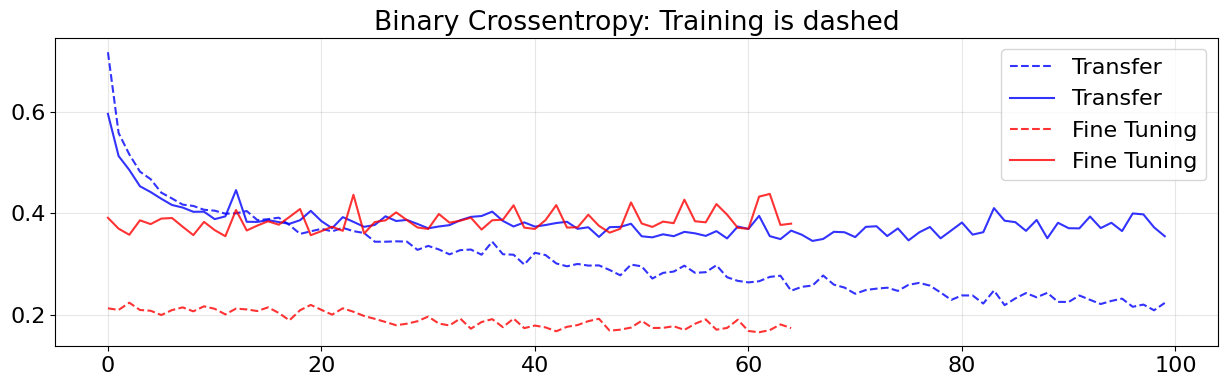

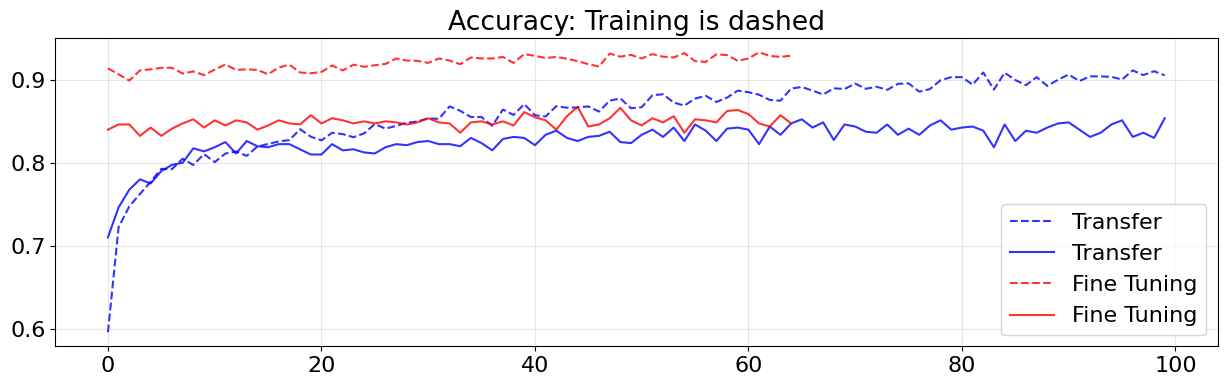

In [32]:
plot_two(histo1, histo1_FT)

### 2.Fit

Because the model didn't fit the test set well enough, we decided to make the model in the second fit more complex.

We add five Dense and three Dropout-layer to the output of the CNN to get another out. By taking the average of this two outputs we hope to get a higher accuracy.

In [ ]:
model2 = tfk.models.load_model('Sigmoid/model1_FT')
model2._name = 'model2'
model2.get_layer('mobilenetv2_1.00_96').trainable = False
model2.summary()

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_4[0][0]']             
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 1280)                 2257984   ['preprocessing[0][0]']       
 ional)                                                                                           
                                                                                                  
 Dense1 (Dense)              (None, 100)                  128100    ['mobilenetv2_1.00_96[0][

In [ ]:
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(mode='horizontal_and_vertical', name='randomFlip'),
        tfkl.RandomTranslation(0.2,0.2,name='randomTrans'),
    ], name='preprocessing')

inputs = tfk.Input(shape=(96, 96, 3))
preprocessing = preprocessing(inputs)

cnn_out = model2.get_layer('mobilenetv2_1.00_96')(preprocessing)
d1 = model2.get_layer('Dense1')(cnn_out)

b1 = model2.get_layer('block_1')(d1)
add1 = model2.get_layer('add1')([d1,b1])

d2 = model2.get_layer('Dense2')(add1)
b2 = model2.get_layer('block_2')(d2)
add2 = model2.get_layer('add2')([add1,b2])

d4 = model2.get_layer('Dense4')(add2)
out0 = model2.get_layer('out')(d4)


d3 = tfkl.Dense(units=100, activation='relu', name='Dense3')(cnn_out)
b3 = block('block_3')(d3)
out1 = tfkl.Dense(units=1, activation='sigmoid', name='out1')(b3)

outputs = tfkl.Average(name='avg')([out0,out1])

model2 = tfk.Model(inputs=inputs, outputs=outputs, name='model2')
model2.summary()

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_4[0][0]']             
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 1280)                 2257984   ['preprocessing[0][0]']       
 ional)                                                                                           
                                                                                                  
 Dense1 (Dense)              (None, 100)                  128100    ['mobilenetv2_1.00_96[1][

In [ ]:
model2.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model2.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
  ).history

Epoch 1/100
13/13 [==============================] - 60s 4s/step - loss: 0.3440 - accuracy: 0.9147 - val_loss: 0.4040 - val_accuracy: 0.8439
Epoch 2/100
13/13 [==============================] - 41s 3s/step - loss: 0.2982 - accuracy: 0.9013 - val_loss: 0.3728 - val_accuracy: 0.8527
Epoch 3/100
13/13 [==============================] - 42s 3s/step - loss: 0.2798 - accuracy: 0.9122 - val_loss: 0.3843 - val_accuracy: 0.8664
Epoch 4/100
13/13 [==============================] - 38s 3s/step - loss: 0.2750 - accuracy: 0.9088 - val_loss: 0.3614 - val_accuracy: 0.8514
Epoch 5/100
13/13 [==============================] - 42s 3s/step - loss: 0.2672 - accuracy: 0.9060 - val_loss: 0.4071 - val_accuracy: 0.8414
Epoch 6/100
13/13 [==============================] - 36s 3s/step - loss: 0.2743 - accuracy: 0.9066 - val_loss: 0.3601 - val_accuracy: 0.8377
Epoch 7/100
13/13 [==============================] - 36s 3s/step - loss: 0.2636 - accuracy: 0.9076 - val_loss: 0.3647 - val_accuracy: 0.8564
Epoch 8/100
1

In [ ]:
save_model(model2, 'model2', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)
del history, model2

### 2. Fit Load

In [7]:
model2, loss2, val_loss2, acc2, val_acc2 = load_model('Sigmoid/model2')

histo2 = [loss2, val_loss2, acc2, val_acc2]
print('Validation accuracy:')
val_acc2 = validation(model2, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc2 = validation(model2, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 6s 223ms/step
Accuracy of the original test set: 0.8664
Accuracy of the horizontally flipped test set: 0.8277
Accuracy of the vertically flipped test set: 0.8427
Mean accuracy of the three predictions above: 0.8452
Accuracy of the right-down shifted test set: 0.7953
Accuracy of the right-upper shifted test set: 0.7865
Accuracy of the left-down shifted test set: 0.7765
Accuracy of the left-upper shifted test set: 0.7878
Mean accuracy of the shifted test sets: 0.8252
Mean accuracy of all test sets: 0.8327
Test accuracy:
32/32 [==============================] - 7s 223ms/step
Accuracy of the original test set: 0.8372
Accuracy of the horizontally flipped test set: 0.8362
Accuracy of the vertically flipped test set: 0.8511
Mean accuracy of the three predictions above: 0.8561
Accuracy of the right-down shifted test set: 0.7872
Accuracy of the right-upper shifted test set: 0.8022
Accuracy of the left-down shifted test set: 0.7852
Ac

### 2. Fit Fine Tuning

We did another FineTuning, but this time we unfreezed the layer 125 up to the layer 154 of the MobileNetV2.

In [ ]:
model2_FT = tfk.models.load_model('Sigmoid/model2')
model2_FT._name = 'model2_FT'

model2_FT.get_layer('mobilenetv2_1.00_96').trainable = True
N = 125
for i, layer in enumerate(model2_FT.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
model2_FT.summary()

Model: "model2_FT"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_4[0][0]']             
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 1280)                 2257984   ['preprocessing[0][0]']       
 ional)                                                                                           
                                                                                                  
 Dense1 (Dense)              (None, 100)                  128100    ['mobilenetv2_1.00_96[

In [ ]:
model2_FT.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model2_FT.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
  ).history

Epoch 1/100
13/13 [==============================] - 67s 4s/step - loss: 0.5565 - accuracy: 0.7270 - val_loss: 0.7206 - val_accuracy: 0.6704
Epoch 2/100
13/13 [==============================] - 54s 4s/step - loss: 0.4485 - accuracy: 0.7954 - val_loss: 0.8212 - val_accuracy: 0.6567
Epoch 3/100
13/13 [==============================] - 53s 4s/step - loss: 0.4187 - accuracy: 0.8079 - val_loss: 0.7026 - val_accuracy: 0.6991
Epoch 4/100
13/13 [==============================] - 53s 4s/step - loss: 0.3908 - accuracy: 0.8142 - val_loss: 0.8114 - val_accuracy: 0.7266
Epoch 5/100
13/13 [==============================] - 57s 5s/step - loss: 0.3693 - accuracy: 0.8420 - val_loss: 1.8479 - val_accuracy: 0.6704
Epoch 6/100
13/13 [==============================] - 51s 4s/step - loss: 0.3651 - accuracy: 0.8413 - val_loss: 1.1510 - val_accuracy: 0.7016
Epoch 7/100
13/13 [==============================] - 57s 4s/step - loss: 0.3440 - accuracy: 0.8410 - val_loss: 1.6400 - val_accuracy: 0.6916
Epoch 8/100
1

In [ ]:
save_model(model2_FT, 'model2_FT', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)
del history, model2_FT

### 2. Fit Fine Tuning Load

In [8]:
model2_FT, loss2_FT, val_loss2_FT, acc2_FT, val_acc2_FT = load_model('Sigmoid/model2_FT')

histo2_FT = [loss2_FT, val_loss2_FT, acc2_FT, val_acc2_FT]
print('Validation accuracy:')
val_acc2_FT = validation(model2_FT, x_val_del_mobile, argMax_y_val_del,True)
print('Test accuracy:')
test_acc2_FT = validation(model2_FT, x_test_del_mobile, argMax_y_test_del,True)

Validation accuracy:
26/26 [==============================] - 5s 206ms/step
Accuracy of the original test set: 0.8177
Accuracy of the horizontally flipped test set: 0.784
Accuracy of the vertically flipped test set: 0.8202
Mean accuracy of the three predictions above: 0.819
Accuracy of the right-down shifted test set: 0.7803
Accuracy of the right-upper shifted test set: 0.7778
Accuracy of the left-down shifted test set: 0.7803
Accuracy of the left-upper shifted test set: 0.7915
Mean accuracy of the shifted test sets: 0.824
Mean accuracy of all test sets: 0.8265
Test accuracy:
32/32 [==============================] - 5s 157ms/step
Accuracy of the original test set: 0.8162
Accuracy of the horizontally flipped test set: 0.8242
Accuracy of the vertically flipped test set: 0.8082
Mean accuracy of the three predictions above: 0.8272
Accuracy of the right-down shifted test set: 0.8012
Accuracy of the right-upper shifted test set: 0.7822
Accuracy of the left-down shifted test set: 0.7682
Accur

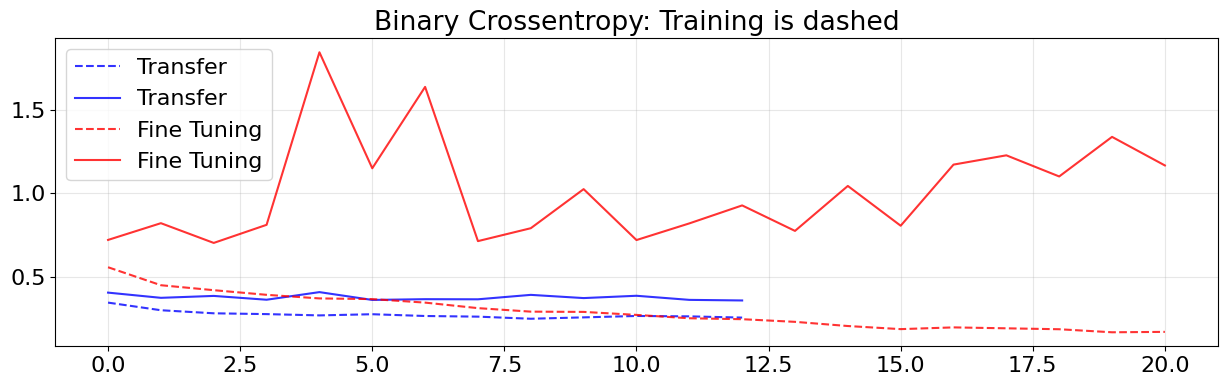

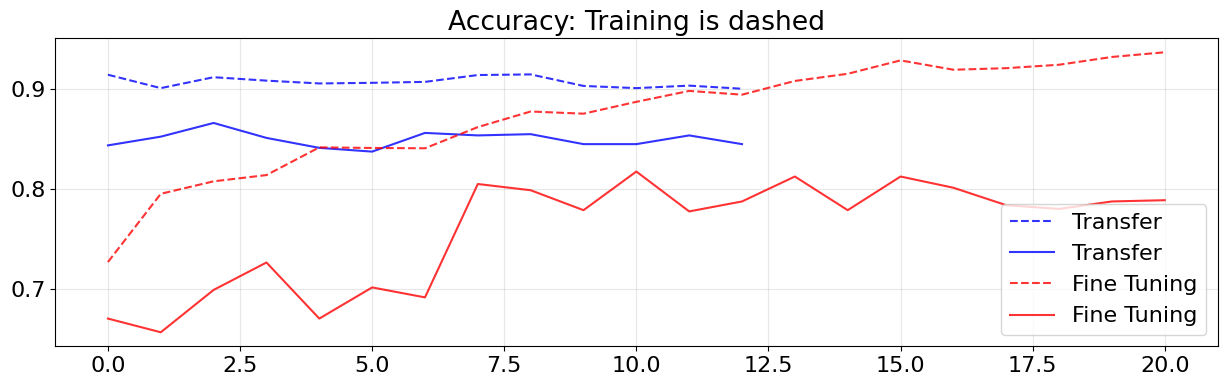

In [9]:
plot_two(histo2, histo2_FT)

### 2. Fit FineTuning2

Now we used the AdamW optimizer which performed better than the Adam optimizer.

In [ ]:
model2_FT2 = tfk.models.load_model('Sigmoid/model2_FT')
model2_FT2._name = 'model2_FT2'

In [ ]:
model2_FT2.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

In [ ]:
history = model2_FT2.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 50,
    validation_data = (x_val_del_mobile, argMax_y_val_del)
  ).history

Epoch 1/50
13/13 [==============================] - 62s 5s/step - loss: 0.1803 - accuracy: 0.9304 - val_loss: 1.0050 - val_accuracy: 0.7853
Epoch 2/50
13/13 [==============================] - 63s 5s/step - loss: 0.1671 - accuracy: 0.9369 - val_loss: 1.0375 - val_accuracy: 0.7715
Epoch 3/50
13/13 [==============================] - 54s 4s/step - loss: 0.1643 - accuracy: 0.9410 - val_loss: 1.4812 - val_accuracy: 0.7541
Epoch 4/50
13/13 [==============================] - 52s 4s/step - loss: 0.1621 - accuracy: 0.9369 - val_loss: 0.8231 - val_accuracy: 0.7678
Epoch 5/50
13/13 [==============================] - 51s 4s/step - loss: 0.1502 - accuracy: 0.9397 - val_loss: 0.7463 - val_accuracy: 0.7678
Epoch 6/50
13/13 [==============================] - 54s 4s/step - loss: 0.1487 - accuracy: 0.9413 - val_loss: 0.8478 - val_accuracy: 0.7603
Epoch 7/50
13/13 [==============================] - 53s 4s/step - loss: 0.1471 - accuracy: 0.9441 - val_loss: 0.7146 - val_accuracy: 0.7665
Epoch 8/50
13/13 [==

In [ ]:
save_model(model2_FT2, 'model2_FT2', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)
del history, model2_FT2

### 2. Fit FineTuning2 Load

In [10]:
model2_FT2, loss2_FT2, val_loss2_FT2, acc2_FT2, val_acc2_FT2 = load_model('Sigmoid/model2_FT2')

histo2_FT2 = [loss2_FT2, val_loss2_FT2, acc2_FT2, val_acc2_FT2]
print('Validation accuracy:')
val_acc2_FT2 = validation(model2_FT2, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc2_FT2 = validation(model2_FT2, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 7s 272ms/step
Accuracy of the original test set: 0.7278
Accuracy of the horizontally flipped test set: 0.7428
Accuracy of the vertically flipped test set: 0.7316
Mean accuracy of the three predictions above: 0.7353
Accuracy of the right-down shifted test set: 0.6742
Accuracy of the right-upper shifted test set: 0.6729
Accuracy of the left-down shifted test set: 0.6742
Accuracy of the left-upper shifted test set: 0.6692
Mean accuracy of the shifted test sets: 0.6717
Mean accuracy of all test sets: 0.6891
Test accuracy:
32/32 [==============================] - 7s 209ms/step
Accuracy of the original test set: 0.7193
Accuracy of the horizontally flipped test set: 0.7393
Accuracy of the vertically flipped test set: 0.7213
Mean accuracy of the three predictions above: 0.7163
Accuracy of the right-down shifted test set: 0.6673
Accuracy of the right-upper shifted test set: 0.6733
Accuracy of the left-down shifted test set: 0.6623
Ac

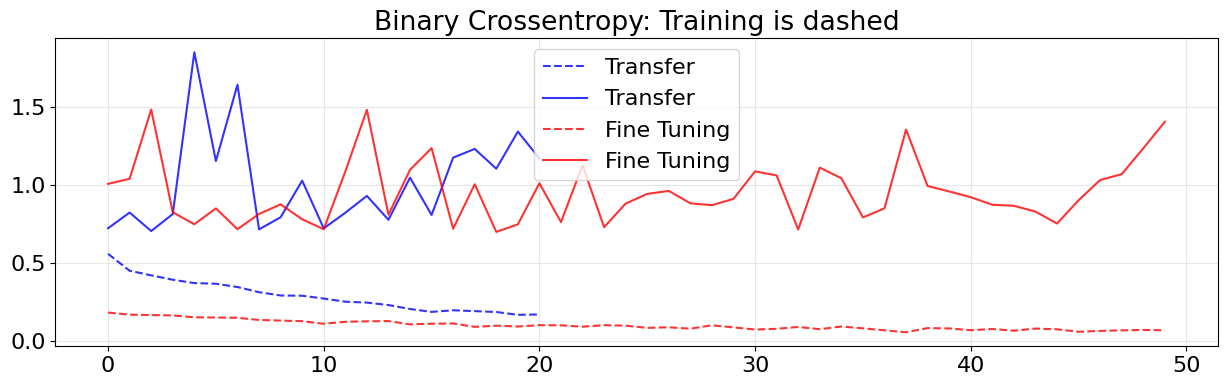

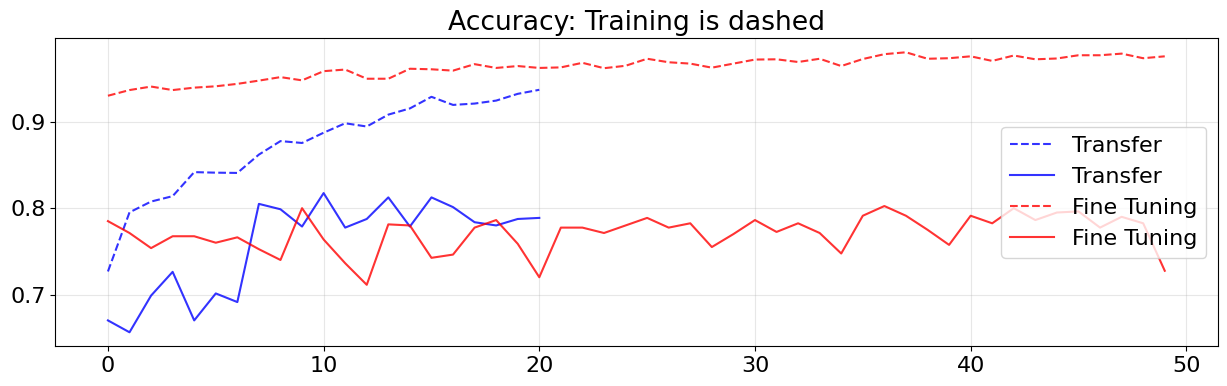

In [11]:
plot_two(histo2_FT, histo2_FT2)

### 2. Fit2 adding Dropout

But then we ran into overfitting, so we added one more Dropout-Layers right after the CNN.

We trained the model twice, one time with AdamW() and one time with AdamW(learning_rate=1e-5, weight_decay=5e-4)

In [18]:
model2_FT2_Dropout = tfk.models.load_model('Sigmoid/model2_FT')
model2_FT2_Dropout._name = 'model2_FT2_Dropout'
model2_FT2_Dropout.get_layer('mobilenetv2_1.00_96').trainable = False

In [19]:
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(mode='horizontal_and_vertical', name='randomFlip'),
        tfkl.RandomTranslation(0.2,0.2,name='randomTrans'),
    ], name='preprocessing')

inputs = tfk.Input(shape=(96, 96, 3))
preprocessing = preprocessing(inputs)

cnn_out = model2_FT2_Dropout.get_layer('mobilenetv2_1.00_96')(preprocessing)
cnn_dropout = tfkl.Dropout(1/6, name='cnn_dropout')(cnn_out)

d1 = model2_FT2_Dropout.get_layer('Dense1')(cnn_out)

b1 = model2_FT2_Dropout.get_layer('block_1')(d1)
add1 = model2_FT2_Dropout.get_layer('add1')([d1,b1])

d2 = model2_FT2_Dropout.get_layer('Dense2')(add1)
b2 = model2_FT2_Dropout.get_layer('block_2')(d2)
add2 = model2_FT2_Dropout.get_layer('add2')([add1,b2])

d4 = model2_FT2_Dropout.get_layer('Dense4')(add2)
out0 = model2_FT2_Dropout.get_layer('out')(d4)


d3 = model2_FT2_Dropout.get_layer('Dense3')(cnn_out)
b3 = model2_FT2_Dropout.get_layer('block_3')(d3)
out1 = model2_FT2_Dropout.get_layer('out1')(b3)

outputs = model2_FT2_Dropout.get_layer('avg')([out0,out1])

model2_FT2_Dropout = tfk.Model(inputs=inputs, outputs=outputs, name='model2_FT2_Dropout')
model2_FT2_Dropout.summary()

Model: "model2_FT2_Dropout"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 1280)                 2257984   ['preprocessing[0][0]']       
 ional)                                                                                           
                                                                                                  
 Dense1 (Dense)              (None, 100)                  128100    ['mobilenetv2

In [20]:
model2_FT2_Dropout.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

In [21]:
history = model2_FT2_Dropout.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
  ).history

Epoch 1/100
13/13 [==============================] - 52s 3s/step - loss: 0.3577 - accuracy: 0.8538 - val_loss: 0.4210 - val_accuracy: 0.8127
Epoch 2/100
13/13 [==============================] - 38s 3s/step - loss: 0.3234 - accuracy: 0.8666 - val_loss: 0.4296 - val_accuracy: 0.8165
Epoch 3/100
13/13 [==============================] - 38s 3s/step - loss: 0.3205 - accuracy: 0.8638 - val_loss: 0.3865 - val_accuracy: 0.8327
Epoch 4/100
13/13 [==============================] - 40s 3s/step - loss: 0.3059 - accuracy: 0.8716 - val_loss: 0.3802 - val_accuracy: 0.8390
Epoch 5/100
13/13 [==============================] - 41s 3s/step - loss: 0.2877 - accuracy: 0.8785 - val_loss: 0.3785 - val_accuracy: 0.8252
Epoch 6/100
13/13 [==============================] - 39s 3s/step - loss: 0.2920 - accuracy: 0.8770 - val_loss: 0.3859 - val_accuracy: 0.8327
Epoch 7/100
13/13 [==============================] - 38s 3s/step - loss: 0.2904 - accuracy: 0.8788 - val_loss: 0.3780 - val_accuracy: 0.8402
Epoch 8/100
1

In [22]:
save_model(model2_FT2_Dropout, 'model2_FT2_Dropout', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)

In [23]:
model2_FT2_Dropout.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-5, weight_decay=5e-4), metrics=['accuracy'])

In [24]:
history = model2_FT2_Dropout.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
  ).history

Epoch 1/100
13/13 [==============================] - 52s 3s/step - loss: 0.2195 - accuracy: 0.9072 - val_loss: 0.3761 - val_accuracy: 0.8652
Epoch 2/100
13/13 [==============================] - 40s 3s/step - loss: 0.2124 - accuracy: 0.9172 - val_loss: 0.3749 - val_accuracy: 0.8639
Epoch 3/100
13/13 [==============================] - 39s 3s/step - loss: 0.2154 - accuracy: 0.9132 - val_loss: 0.3737 - val_accuracy: 0.8627
Epoch 4/100
13/13 [==============================] - 38s 3s/step - loss: 0.2402 - accuracy: 0.8979 - val_loss: 0.3722 - val_accuracy: 0.8614
Epoch 5/100
13/13 [==============================] - 39s 3s/step - loss: 0.2145 - accuracy: 0.9144 - val_loss: 0.3709 - val_accuracy: 0.8589
Epoch 6/100
13/13 [==============================] - 40s 3s/step - loss: 0.2345 - accuracy: 0.9004 - val_loss: 0.3695 - val_accuracy: 0.8602
Epoch 7/100
13/13 [==============================] - 42s 3s/step - loss: 0.2252 - accuracy: 0.9085 - val_loss: 0.3683 - val_accuracy: 0.8602
Epoch 8/100
1

In [25]:
save_model(model2_FT2_Dropout, 'model2_FT2_Dropout2', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)

### 2. Fit2 adding Dropout Load

In [26]:
model2_FT2_Dropout, loss2_FT2_Dropout, val_loss2_FT2_Dropout, acc2_FT2_Dropout, val_acc2_FT2_Dropout = load_model('Sigmoid/model2_FT2_Dropout')

histo2_FT2_Dropout = [loss2_FT2_Dropout, val_loss2_FT2_Dropout, acc2_FT2_Dropout, val_acc2_FT2_Dropout]
print('Validation accuracy:')
val_acc2_FT2_Dropout = validation(model2_FT2_Dropout, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc2_FT2_Dropout = validation(model2_FT2_Dropout, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 6s 234ms/step
Accuracy of the original test set: 0.8639
Accuracy of the horizontally flipped test set: 0.839
Accuracy of the vertically flipped test set: 0.8539
Mean accuracy of the three predictions above: 0.8627
Accuracy of the right-down shifted test set: 0.7965
Accuracy of the right-upper shifted test set: 0.8127
Accuracy of the left-down shifted test set: 0.8165
Accuracy of the left-upper shifted test set: 0.814
Mean accuracy of the shifted test sets: 0.8552
Mean accuracy of all test sets: 0.8614
Test accuracy:
32/32 [==============================] - 5s 169ms/step
Accuracy of the original test set: 0.8462
Accuracy of the horizontally flipped test set: 0.8601
Accuracy of the vertically flipped test set: 0.8541
Mean accuracy of the three predictions above: 0.8701
Accuracy of the right-down shifted test set: 0.8282
Accuracy of the right-upper shifted test set: 0.8092
Accuracy of the left-down shifted test set: 0.8072
Accu

In [37]:
model2_FT2_Dropout2, loss2_FT2_Dropout2, val_loss2_FT2_Dropout2, acc2_FT2_Dropout2, val_acc2_FT2_Dropout2 = load_model('Sigmoid/model2_FT2_Dropout2')

histo2_FT2_Dropout2 = [loss2_FT2_Dropout2, val_loss2_FT2_Dropout2, acc2_FT2_Dropout2, val_acc2_FT2_Dropout2]
print('Validation accuracy:')
val_acc2_FT2_Dropout2 = validation(model2_FT2_Dropout2, x_val_del_mobile, argMax_y_val_del,True)
print('Test accuracy:')
test_acc2_FT2_Dropout2 = validation(model2_FT2_Dropout2, x_test_del_mobile, argMax_y_test_del,True)

Validation accuracy:
26/26 [==============================] - 6s 233ms/step
Accuracy of the original test set: 0.8652
Accuracy of the horizontally flipped test set: 0.839
Accuracy of the vertically flipped test set: 0.8539
Mean accuracy of the three predictions above: 0.8627
Accuracy of the right-down shifted test set: 0.7978
Accuracy of the right-upper shifted test set: 0.8177
Accuracy of the left-down shifted test set: 0.8165
Accuracy of the left-upper shifted test set: 0.8152
Mean accuracy of the shifted test sets: 0.8577
Mean accuracy of all test sets: 0.8627
Test accuracy:
32/32 [==============================] - 9s 275ms/step
Accuracy of the original test set: 0.8472
Accuracy of the horizontally flipped test set: 0.8601
Accuracy of the vertically flipped test set: 0.8501
Mean accuracy of the three predictions above: 0.8691
Accuracy of the right-down shifted test set: 0.8302
Accuracy of the right-upper shifted test set: 0.8122
Accuracy of the left-down shifted test set: 0.8062
Acc

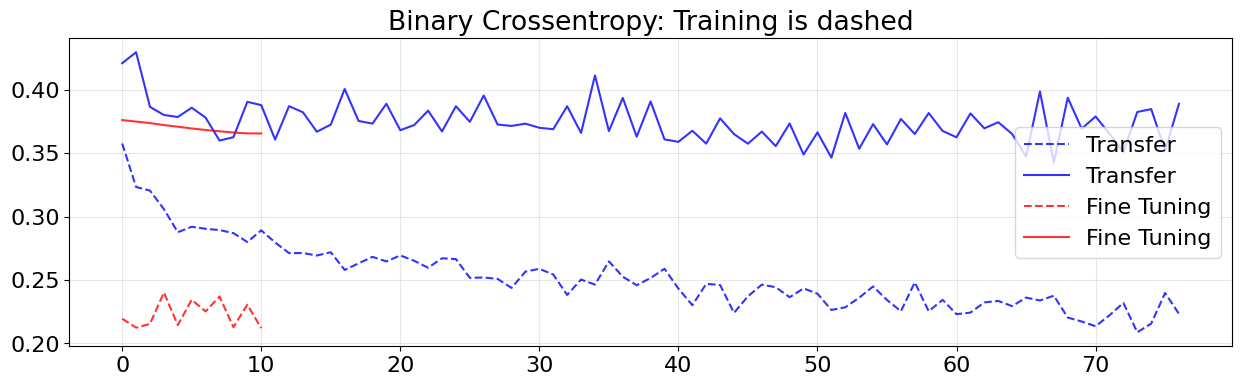

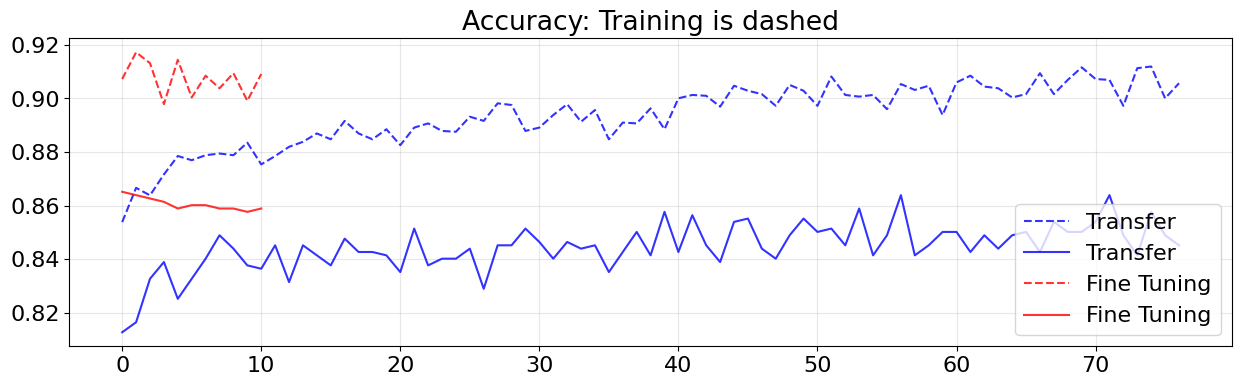

In [38]:
plot_two(histo2_FT2_Dropout, histo2_FT2_Dropout2)

### 3. Fit

In the third fit we also added Brightness and Zoom.
We added the Image Augmentation one after another because the network wasnt able to handle all at the same time.

In [39]:
model3 = tfk.models.load_model('Sigmoid/model2_FT2_Dropout2')
model3._name = 'model3'
model3.get_layer('mobilenetv2_1.00_96').trainable = False

In [42]:
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(mode='horizontal_and_vertical', name='randomFlip'),
        tfkl.RandomTranslation(0.2,0.2,name='randomTrans'),
        tf.keras.layers.RandomBrightness(0.2, value_range=(-1,1), name='randomBrig'),
    ], name='preprocessing')

inputs = tfk.Input(shape=(96, 96, 3))
preprocessing = preprocessing(inputs)

cnn_out = model3.get_layer('mobilenetv2_1.00_96')(preprocessing)
cnn_dropout = tfkl.Dropout(1/6, name='cnn_dropout')(cnn_out)

d1 = model3.get_layer('Dense1')(cnn_out)

b1 = model3.get_layer('block_1')(d1)
add1 = model3.get_layer('add1')([d1,b1])

d2 = model3.get_layer('Dense2')(add1)
b2 = model3.get_layer('block_2')(d2)
add2 = model3.get_layer('add2')([add1,b2])

d4 = model3.get_layer('Dense4')(add2)
out0 = model3.get_layer('out')(d4)


d3 = model3.get_layer('Dense3')(cnn_out)
b3 = model3.get_layer('block_3')(d3)
out1 = model3.get_layer('out1')(b3)

concat1 = tfkl.Concatenate()([d4,b3])
b4 = block_withLambda('block_4', dropout_rate = 1/6, l2_lambda = 2e-6)(concat1)
out2 = tfkl.Dense(units=1,activation='sigmoid', name='out2')(b4)

outputs = model2_FT2_Dropout.get_layer('avg')([out0,out1,out2])

model3 = tfk.Model(inputs=inputs, outputs=outputs, name='model3')
model3.summary()

Model: "model3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_3[0][0]']             
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 1280)                 2257984   ['preprocessing[0][0]']       
 ional)                                                                                           
                                                                                                  
 Dense1 (Dense)              (None, 100)                  128100    ['mobilenetv2_1.00_96[2][

In [43]:
model3.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

In [44]:
history = model3.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
  ).history

Epoch 1/100
13/13 [==============================] - 48s 3s/step - loss: 0.2830 - accuracy: 0.8873 - val_loss: 0.4247 - val_accuracy: 0.8477
Epoch 2/100
13/13 [==============================] - 41s 3s/step - loss: 0.2698 - accuracy: 0.8848 - val_loss: 0.3462 - val_accuracy: 0.8502
Epoch 3/100
13/13 [==============================] - 41s 3s/step - loss: 0.2460 - accuracy: 0.8963 - val_loss: 0.3802 - val_accuracy: 0.8477
Epoch 4/100
13/13 [==============================] - 38s 3s/step - loss: 0.2397 - accuracy: 0.8982 - val_loss: 0.3800 - val_accuracy: 0.8577
Epoch 5/100
13/13 [==============================] - 39s 3s/step - loss: 0.2307 - accuracy: 0.8991 - val_loss: 0.3855 - val_accuracy: 0.8502
Epoch 6/100
13/13 [==============================] - 41s 3s/step - loss: 0.2365 - accuracy: 0.9022 - val_loss: 0.3801 - val_accuracy: 0.8577
Epoch 7/100
13/13 [==============================] - 41s 3s/step - loss: 0.2623 - accuracy: 0.8857 - val_loss: 0.3664 - val_accuracy: 0.8527
Epoch 8/100
1

In [45]:
save_model(model3, 'model3', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)
del history, model3

### 3. Fit Load

In [46]:
model3, loss3, val_loss3, acc3, val_acc3 = load_model('Sigmoid/model3')

histo3 = [loss3, val_loss3, acc3, val_acc3]
print('Validation accuracy:')
val_acc3 = validation(model3, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc3 = validation(model3, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 4s 165ms/step
Accuracy of the original test set: 0.8689
Accuracy of the horizontally flipped test set: 0.8414
Accuracy of the vertically flipped test set: 0.8564
Mean accuracy of the three predictions above: 0.8627
Accuracy of the right-down shifted test set: 0.794
Accuracy of the right-upper shifted test set: 0.8002
Accuracy of the left-down shifted test set: 0.8177
Accuracy of the left-upper shifted test set: 0.8052
Mean accuracy of the shifted test sets: 0.8627
Mean accuracy of all test sets: 0.8702
Test accuracy:
32/32 [==============================] - 12s 371ms/step
Accuracy of the original test set: 0.8452
Accuracy of the horizontally flipped test set: 0.8402
Accuracy of the vertically flipped test set: 0.8492
Mean accuracy of the three predictions above: 0.8581
Accuracy of the right-down shifted test set: 0.8262
Accuracy of the right-upper shifted test set: 0.8232
Accuracy of the left-down shifted test set: 0.8062
Ac

### 3. Fit2

We are adding RandomZoom.

In [47]:
model3 = tfk.models.load_model('Sigmoid/model3')

In [48]:
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(mode='horizontal_and_vertical', name='randomFlip'),
        tfkl.RandomTranslation(0.2,0.2,name='randomTrans'),
        tfkl.RandomBrightness(0.2, value_range=(-1,1), name='randomBrig'),
        tfkl.RandomZoom(0.2, name='randomZoom'),
    ], name='preprocessing')

inputs = tfk.Input(shape=(96, 96, 3))
preprocessing = preprocessing(inputs)

cnn_out = model3.get_layer('mobilenetv2_1.00_96')(preprocessing)
cnn_dropout = tfkl.Dropout(1/6, name='cnn_dropout')(cnn_out)

d1 = model3.get_layer('Dense1')(cnn_dropout)

b1 = model3.get_layer('block_1')(d1)
add1 = model3.get_layer('add1')([d1,b1])

d2 = model3.get_layer('Dense2')(add1)
b2 = model3.get_layer('block_2')(d2)
add2 = model3.get_layer('add2')([add1,b2])

d4 = model3.get_layer('Dense4')(add2)
out0 = model3.get_layer('out')(d4)


d3 = model3.get_layer('Dense3')(cnn_dropout)
b3 = model3.get_layer('block_3')(d3)
out1 = model3.get_layer('out1')(b3)

concat1 = tfkl.Concatenate(name='concat1')([d4,b3])
b4 = model3.get_layer('block_4')(concat1)
out2 = model3.get_layer('out2')(b4)

outputs = model3.get_layer('avg')([out0,out1,out2])

model3_2 = tfk.Model(inputs=inputs, outputs=outputs, name='model3_2')
model3_2.summary()

Model: "model3_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_4[0][0]']             
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 1280)                 2257984   ['preprocessing[0][0]']       
 ional)                                                                                           
                                                                                                  
 cnn_dropout (Dropout)       (None, 1280)                 0         ['mobilenetv2_1.00_96[1

In [49]:
model3_2.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

In [50]:
history = model3_2.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
  ).history

Epoch 1/100
13/13 [==============================] - 55s 3s/step - loss: 0.3180 - accuracy: 0.8691 - val_loss: 0.3576 - val_accuracy: 0.8464
Epoch 2/100
13/13 [==============================] - 43s 3s/step - loss: 0.3098 - accuracy: 0.8654 - val_loss: 0.3716 - val_accuracy: 0.8315
Epoch 3/100
13/13 [==============================] - 45s 4s/step - loss: 0.2913 - accuracy: 0.8795 - val_loss: 0.3788 - val_accuracy: 0.8477
Epoch 4/100
13/13 [==============================] - 43s 3s/step - loss: 0.2925 - accuracy: 0.8732 - val_loss: 0.3811 - val_accuracy: 0.8402
Epoch 5/100
13/13 [==============================] - 45s 4s/step - loss: 0.2990 - accuracy: 0.8726 - val_loss: 0.3939 - val_accuracy: 0.8277
Epoch 6/100
13/13 [==============================] - 45s 3s/step - loss: 0.3033 - accuracy: 0.8729 - val_loss: 0.3790 - val_accuracy: 0.8290
Epoch 7/100
13/13 [==============================] - 41s 3s/step - loss: 0.2928 - accuracy: 0.8682 - val_loss: 0.4076 - val_accuracy: 0.8240
Epoch 8/100
1

In [51]:
save_model(model3_2, 'model3_2', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)

In [52]:
model3_2.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-5, weight_decay=5e-4), metrics=['accuracy'])

In [53]:
history = model3_2.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
  ).history

Epoch 1/100
13/13 [==============================] - 55s 4s/step - loss: 0.2988 - accuracy: 0.8745 - val_loss: 0.3783 - val_accuracy: 0.8464
Epoch 2/100
13/13 [==============================] - 42s 3s/step - loss: 0.2886 - accuracy: 0.8760 - val_loss: 0.3771 - val_accuracy: 0.8464
Epoch 3/100
13/13 [==============================] - 38s 3s/step - loss: 0.2828 - accuracy: 0.8738 - val_loss: 0.3775 - val_accuracy: 0.8464
Epoch 4/100
13/13 [==============================] - 45s 3s/step - loss: 0.3013 - accuracy: 0.8673 - val_loss: 0.3772 - val_accuracy: 0.8452
Epoch 5/100
13/13 [==============================] - 43s 3s/step - loss: 0.2825 - accuracy: 0.8860 - val_loss: 0.3770 - val_accuracy: 0.8452
Epoch 6/100
13/13 [==============================] - 44s 3s/step - loss: 0.3015 - accuracy: 0.8663 - val_loss: 0.3759 - val_accuracy: 0.8390
Epoch 7/100
13/13 [==============================] - 43s 3s/step - loss: 0.3160 - accuracy: 0.8638 - val_loss: 0.3745 - val_accuracy: 0.8390
Epoch 8/100
1

In [54]:
save_model(model3_2, 'model3_3', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)

### 3. Fit2 Load

In [55]:
model3_2, loss3_2, val_loss3_2, acc3_2, val_acc3_2 = load_model('Sigmoid/model3_2')

histo3_2 = [loss3_2, val_loss3_2, acc3_2, val_acc3_2]
print('Validation accuracy:')
val_acc3_2 = validation(model3_2, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc3_2 = validation(model3_2, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 8s 304ms/step
Accuracy of the original test set: 0.8477
Accuracy of the horizontally flipped test set: 0.8265
Accuracy of the vertically flipped test set: 0.8414
Mean accuracy of the three predictions above: 0.8502
Accuracy of the right-down shifted test set: 0.8065
Accuracy of the right-upper shifted test set: 0.799
Accuracy of the left-down shifted test set: 0.8065
Accuracy of the left-upper shifted test set: 0.8002
Mean accuracy of the shifted test sets: 0.8564
Mean accuracy of all test sets: 0.8552
Test accuracy:
32/32 [==============================] - 9s 265ms/step
Accuracy of the original test set: 0.8352
Accuracy of the horizontally flipped test set: 0.8272
Accuracy of the vertically flipped test set: 0.8482
Mean accuracy of the three predictions above: 0.8492
Accuracy of the right-down shifted test set: 0.8202
Accuracy of the right-upper shifted test set: 0.8062
Accuracy of the left-down shifted test set: 0.7942
Acc

In [56]:
model3_3, loss3_3, val_loss3_3, acc3_3, val_acc3_3 = load_model('Sigmoid/model3_3')

histo3_3 = [loss3_3, val_loss3_3, acc3_3, val_acc3_3]
print('Validation accuracy:')
val_acc3_3 = validation(model3_3, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc3_3 = validation(model3_3, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 4s 167ms/step
Accuracy of the original test set: 0.8464
Accuracy of the horizontally flipped test set: 0.8277
Accuracy of the vertically flipped test set: 0.8414
Mean accuracy of the three predictions above: 0.8502
Accuracy of the right-down shifted test set: 0.804
Accuracy of the right-upper shifted test set: 0.8002
Accuracy of the left-down shifted test set: 0.8052
Accuracy of the left-upper shifted test set: 0.8002
Mean accuracy of the shifted test sets: 0.8552
Mean accuracy of all test sets: 0.8552
Test accuracy:
32/32 [==============================] - 6s 182ms/step
Accuracy of the original test set: 0.8362
Accuracy of the horizontally flipped test set: 0.8262
Accuracy of the vertically flipped test set: 0.8472
Mean accuracy of the three predictions above: 0.8492
Accuracy of the right-down shifted test set: 0.8222
Accuracy of the right-upper shifted test set: 0.8072
Accuracy of the left-down shifted test set: 0.7942
Acc

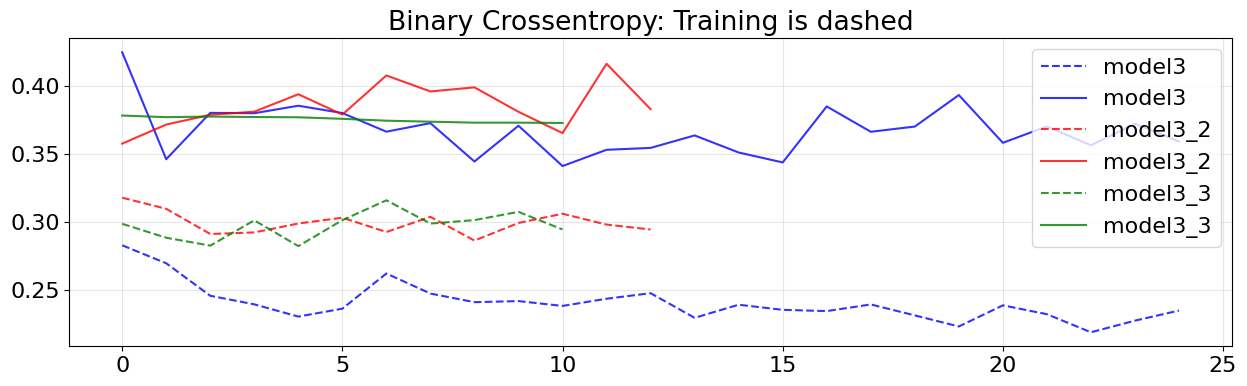

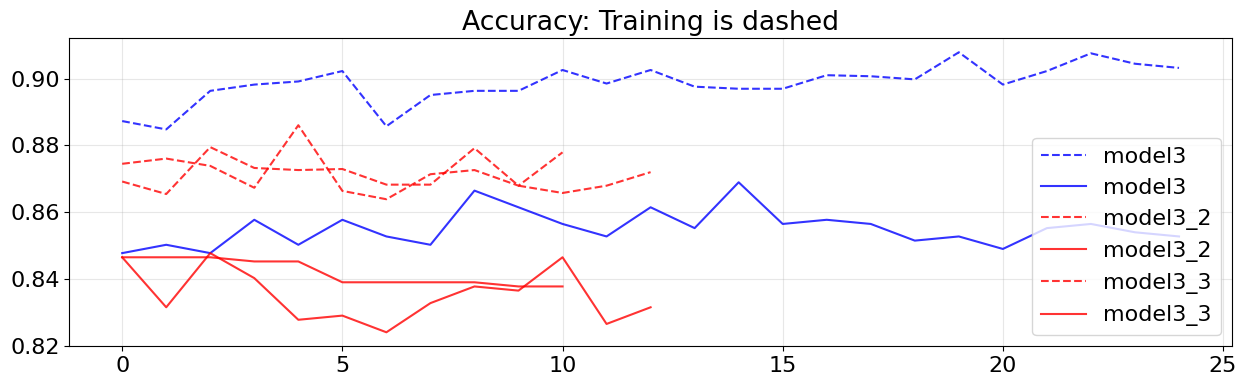

In [57]:
plot_two(histo3, histo3_2, label1='model3', label2='model3_2', histo3=histo3_3, label3='model3_3')

### 4. Fit

Because we didn't get better results on the test set, we decided to train also with the non-sense data. But we didn't get better results on the test set.

In [ ]:
model4 = tfk.models.load_model('Sigmoid/model3_3')

In [ ]:
model4.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model4.fit(
    x = x_train_mobile,
    y = argMax_y_train,
    batch_size = 512,
    epochs = 100,
    validation_data = (x_val_mobile, argMax_y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
  ).history

Epoch 1/100
7/7 [==============================] - 63s 8s/step - loss: 0.2970 - accuracy: 0.8750 - val_loss: 0.2356 - val_accuracy: 0.9111
Epoch 2/100
7/7 [==============================] - 47s 6s/step - loss: 0.2974 - accuracy: 0.8828 - val_loss: 0.2307 - val_accuracy: 0.9099
Epoch 3/100
7/7 [==============================] - 47s 7s/step - loss: 0.2997 - accuracy: 0.8723 - val_loss: 0.2301 - val_accuracy: 0.9159
Epoch 4/100
7/7 [==============================] - 46s 7s/step - loss: 0.2999 - accuracy: 0.8753 - val_loss: 0.2254 - val_accuracy: 0.9135
Epoch 5/100
7/7 [==============================] - 48s 7s/step - loss: 0.2941 - accuracy: 0.8846 - val_loss: 0.2295 - val_accuracy: 0.9062
Epoch 6/100
7/7 [==============================] - 48s 7s/step - loss: 0.2840 - accuracy: 0.8879 - val_loss: 0.2233 - val_accuracy: 0.9159
Epoch 7/100
7/7 [==============================] - 46s 7s/step - loss: 0.3112 - accuracy: 0.8705 - val_loss: 0.2255 - val_accuracy: 0.9183
Epoch 8/100
7/7 [==========

In [ ]:
save_model(model4, 'model4', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)

### 4. Fit Load

In [20]:
model4, loss4, val_loss4, acc4, val_acc4 = load_model('Sigmoid/model4')

histo4 = [loss4, val_loss4, acc4, val_acc4]
print('Validation accuracy:')
val_acc4 = validation(model4, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc4 = validation(model4, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 4s 137ms/step
Accuracy of the original test set: 0.8527
Accuracy of the horizontally flipped test set: 0.8452
Accuracy of the vertically flipped test set: 0.8464
Mean accuracy of the three predictions above: 0.8677
Accuracy of the right-down shifted test set: 0.8102
Accuracy of the right-upper shifted test set: 0.7978
Accuracy of the left-down shifted test set: 0.8052
Accuracy of the left-upper shifted test set: 0.8277
Mean accuracy of the shifted test sets: 0.8627
Mean accuracy of all test sets: 0.8739
Test accuracy:
32/32 [==============================] - 4s 138ms/step
Accuracy of the original test set: 0.8382
Accuracy of the horizontally flipped test set: 0.8531
Accuracy of the vertically flipped test set: 0.8442
Mean accuracy of the three predictions above: 0.8671
Accuracy of the right-down shifted test set: 0.8112
Accuracy of the right-upper shifted test set: 0.8192
Accuracy of the left-down shifted test set: 0.8092
Ac

### 5. Fit

So we made the model again more complex in the fifth fit and added a RandomRotation-Layer. Unfortunately this didn't change anything.

In [ ]:
model5 = tfk.models.load_model('Sigmoid/model3_3')

In [ ]:
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(mode='horizontal_and_vertical', name='randomFlip'),
        tfkl.RandomTranslation(0.2,0.2,name='randomTrans'),
        tfkl.RandomBrightness(0.2, value_range=(-1,1), name='randomBrig'),
        tfkl.RandomZoom(0.2, name='randomZoom'),
        tfkl.RandomRotation(0.2, name='randomRota'),
    ], name='preprocessing')

inputs = tfk.Input(shape=(96, 96, 3))
preprocessing = preprocessing(inputs)

cnn_out = model5.get_layer('mobilenetv2_1.00_96')(preprocessing)
cnn_dropout = tfkl.Dropout(1/6, name='cnn_dropout')(cnn_out)

d1 = model5.get_layer('Dense1')(cnn_dropout)

b1 = model5.get_layer('block_1')(d1)
add1 = model5.get_layer('add1')([d1,b1])

d2 = model5.get_layer('Dense2')(add1)
b2 = model5.get_layer('block_2')(d2)
add2 = model5.get_layer('add2')([add1,b2])

d4 = model5.get_layer('Dense4')(add2)
out0 = model5.get_layer('out')(d4)


d3 = model5.get_layer('Dense3')(cnn_dropout)
b3 = model5.get_layer('block_3')(d3)
out1 = model5.get_layer('out1')(b3)

concat1 = model5.get_layer('concat1')([d4,b3])
b4 = model5.get_layer('block_4')(concat1)
out2 = model5.get_layer('out2')(b4)

concat2 = tfkl.Concatenate(name='concat2')([d4,b3,b4])
b5 = block_withLambda('block_5', dropout_rate = 1/6, l2_lambda = 2e-5)(concat2)
out3 = tfkl.Dense(units=1, activation='sigmoid', name='out3')(b5)

outputs = model5.get_layer('avg')([out0,out1,out2,out3])

model5 = tfk.Model(inputs=inputs, outputs=outputs, name='model5')
model5.summary()

Model: "model5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_2[0][0]']             
                                                                                                  
 mobilenetv2_1.00_96 (Funct  (None, 1280)                 2257984   ['preprocessing[0][0]']       
 ional)                                                                                           
                                                                                                  
 cnn_dropout (Dropout)       (None, 1280)                 0         ['mobilenetv2_1.00_96[2][

In [ ]:
model5.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model5.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
  ).history

Epoch 1/100
13/13 [==============================] - 57s 4s/step - loss: 0.3636 - accuracy: 0.8401 - val_loss: 0.3835 - val_accuracy: 0.8365
Epoch 2/100
13/13 [==============================] - 47s 4s/step - loss: 0.3515 - accuracy: 0.8551 - val_loss: 0.3718 - val_accuracy: 0.8427
Epoch 3/100
13/13 [==============================] - 46s 4s/step - loss: 0.3487 - accuracy: 0.8620 - val_loss: 0.3697 - val_accuracy: 0.8477
Epoch 4/100
13/13 [==============================] - 50s 4s/step - loss: 0.3436 - accuracy: 0.8551 - val_loss: 0.3878 - val_accuracy: 0.8452
Epoch 5/100
13/13 [==============================] - 45s 4s/step - loss: 0.3553 - accuracy: 0.8601 - val_loss: 0.3715 - val_accuracy: 0.8439
Epoch 6/100
13/13 [==============================] - 46s 4s/step - loss: 0.3449 - accuracy: 0.8567 - val_loss: 0.3900 - val_accuracy: 0.8365
Epoch 7/100
13/13 [==============================] - 41s 3s/step - loss: 0.3431 - accuracy: 0.8554 - val_loss: 0.3717 - val_accuracy: 0.8427
Epoch 8/100
1

In [ ]:
save_model(model5, 'model5', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)

In [ ]:
model5.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])
model5._name = 'model5_1'

In [ ]:
history = model5.fit(
    x = x_train_del_mobile,
    y = argMax_y_train_del,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_val_del_mobile, argMax_y_val_del),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
  ).history

Epoch 1/100
13/13 [==============================] - 47s 4s/step - loss: 0.3487 - accuracy: 0.8479 - val_loss: 0.3493 - val_accuracy: 0.8452
Epoch 2/100
13/13 [==============================] - 45s 4s/step - loss: 0.3580 - accuracy: 0.8498 - val_loss: 0.3737 - val_accuracy: 0.8402
Epoch 3/100
13/13 [==============================] - 46s 4s/step - loss: 0.3449 - accuracy: 0.8529 - val_loss: 0.3763 - val_accuracy: 0.8414
Epoch 4/100
13/13 [==============================] - 46s 4s/step - loss: 0.3377 - accuracy: 0.8576 - val_loss: 0.3732 - val_accuracy: 0.8414
Epoch 5/100
13/13 [==============================] - 45s 3s/step - loss: 0.3456 - accuracy: 0.8570 - val_loss: 0.3562 - val_accuracy: 0.8452
Epoch 6/100
13/13 [==============================] - 52s 4s/step - loss: 0.3469 - accuracy: 0.8529 - val_loss: 0.3675 - val_accuracy: 0.8427
Epoch 7/100
13/13 [==============================] - 47s 4s/step - loss: 0.3390 - accuracy: 0.8548 - val_loss: 0.3641 - val_accuracy: 0.8464
Epoch 8/100
1

In [ ]:
save_model(model5, 'model5_1', 'Sigmoid', history['loss'], history['val_loss'], history['accuracy'], history['val_accuracy'], plot=False)

### 5. Fit Load

In [58]:
model5, loss5, val_loss5, acc5, val_acc5 = load_model('Sigmoid/model5')

histo5 = [loss5, val_loss5, acc5, val_acc5]
print('Validation accuracy:')
val_acc5 = validation(model5, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc5 = validation(model5, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 6s 250ms/step
Accuracy of the original test set: 0.8477
Accuracy of the horizontally flipped test set: 0.8527
Accuracy of the vertically flipped test set: 0.8464
Mean accuracy of the three predictions above: 0.8602
Accuracy of the right-down shifted test set: 0.799
Accuracy of the right-upper shifted test set: 0.804
Accuracy of the left-down shifted test set: 0.8127
Accuracy of the left-upper shifted test set: 0.819
Mean accuracy of the shifted test sets: 0.8514
Mean accuracy of all test sets: 0.8627
Test accuracy:
32/32 [==============================] - 7s 214ms/step
Accuracy of the original test set: 0.8302
Accuracy of the horizontally flipped test set: 0.8412
Accuracy of the vertically flipped test set: 0.8402
Mean accuracy of the three predictions above: 0.8472
Accuracy of the right-down shifted test set: 0.8042
Accuracy of the right-upper shifted test set: 0.8082
Accuracy of the left-down shifted test set: 0.8052
Accur

In [59]:
model5_1, loss5_1, val_loss5_1, acc5_1, val_acc5_1 = load_model('Sigmoid/model5_1')

histo5_1 = [loss5_1, val_loss5_1, acc5_1, val_acc5_1]
print('Validation accuracy:')
val_acc5_1 = validation(model5_1, x_val_del_mobile, argMax_y_val_del, True)
print('Test accuracy:')
test_acc5_1 = validation(model5_1, x_test_del_mobile, argMax_y_test_del, True)

Validation accuracy:
26/26 [==============================] - 6s 214ms/step
Accuracy of the original test set: 0.8489
Accuracy of the horizontally flipped test set: 0.8577
Accuracy of the vertically flipped test set: 0.8439
Mean accuracy of the three predictions above: 0.8589
Accuracy of the right-down shifted test set: 0.794
Accuracy of the right-upper shifted test set: 0.8127
Accuracy of the left-down shifted test set: 0.814
Accuracy of the left-upper shifted test set: 0.8165
Mean accuracy of the shifted test sets: 0.8502
Mean accuracy of all test sets: 0.8589
Test accuracy:
32/32 [==============================] - 7s 231ms/step
Accuracy of the original test set: 0.8322
Accuracy of the horizontally flipped test set: 0.8501
Accuracy of the vertically flipped test set: 0.8452
Mean accuracy of the three predictions above: 0.8501
Accuracy of the right-down shifted test set: 0.8082
Accuracy of the right-upper shifted test set: 0.8112
Accuracy of the left-down shifted test set: 0.8042
Accu

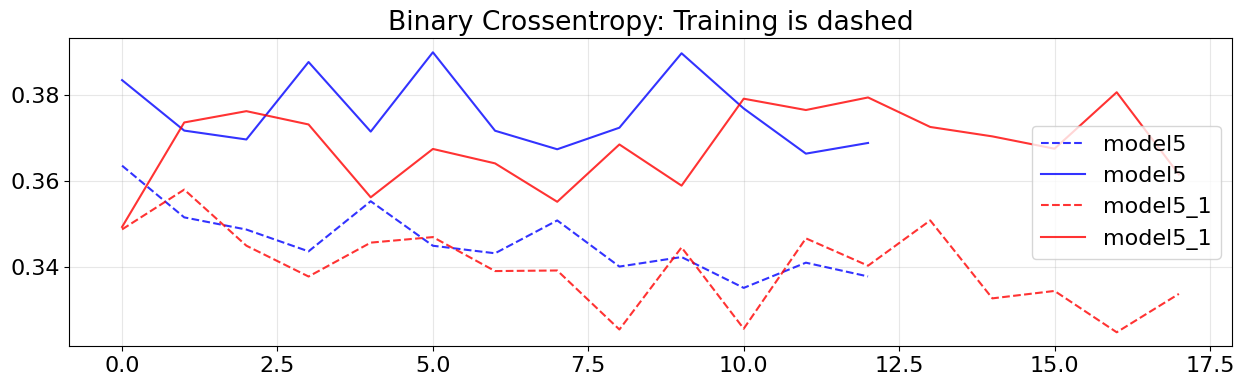

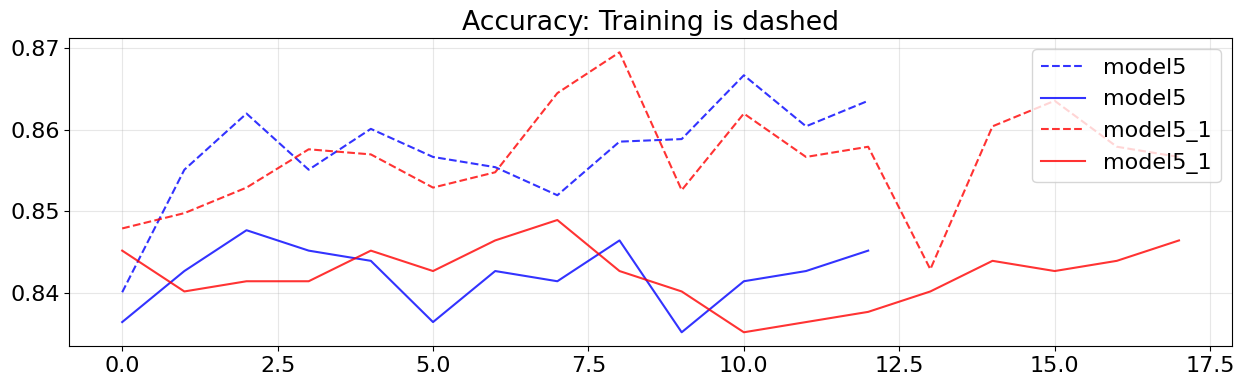

In [60]:
plot_two(histo5, histo5_1, label1='model5', label2='model5_1')

### Results

* The networks wasn't better than 78% in the submission on codalab, these are differences of between 6 and 7 percent in relation to our accuracy on the test set
* The accuracy doesn't increase significantly by using modified input data or taking the mean of all. The differences are between 1 and 2 percent
* The training with the image augmentation by adding one after the other worked very well